In [1]:
# Imports
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Parameters
BATCH_SIZE = 32
IMAGE_SIZE = 256
EPOCHS = 30
CHANNELS = 3
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
   r'C:\Users\VIT-AP\Desktop\Irfan\archive (2)\OralCancer',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names

# Split dataset into training and testing only
def get_train_test_partition(ds, train_split=0.8, test_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size)
    
    # Print dataset sizes for verification
    print(f"Total dataset size: {ds_size}")
    print(f"Training set size: {len(train_ds)}")
    print(f"Test set size: {len(test_ds)}")
    
    # Autotune both datasets
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return train_ds, test_ds

train_ds, test_ds = get_train_test_partition(dataset)

# Define VGG16 model
def create_vgg16_model(input_shape, n_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(n_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Instantiate and train the VGG16 model
vgg16_model = create_vgg16_model(input_shape, len(class_names))
history_vgg16 = vgg16_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS, 
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Evaluate the model on the test set
test_loss_vgg16, test_acc_vgg16 = vgg16_model.evaluate(test_ds)
print(f"VGG16 Test accuracy: {test_acc_vgg16}")




Found 131 files belonging to 2 classes.
Total dataset size: 5
Training set size: 4
Test set size: 1



Epoch 1/30


4/4 [==============================] - 8s 2s/step - loss: 3.7801 - accuracy: 0.5758 - val_loss: 3.2676 - val_accuracy: 0.6667
Epoch 2/30
4/4 [==============================] - 6s 1s/step - loss: 1.6688 - accuracy: 0.7273 - val_loss: 1.6578 - val_accuracy: 0.3333
Epoch 3/30
4/4 [==============================] - 6s 1s/step - loss: 1.3206 - accuracy: 0.7071 - val_loss: 1.5175 - val_accuracy: 0.3333
Epoch 4/30
4/4 [==============================] - 6s 1s/step - loss: 1.4965 - accuracy: 0.7374 - val_loss: 1.4692 - val_accuracy: 0.3333
Epoch 5/30
4/4 [==============================] - 6s 1s/step - loss: 0.7877 - accuracy: 0.8081 - val_loss: 2.1264 - val_accuracy: 0.6667
Epoch 6/30
4/4 [==============================] - 6s 1s/step - loss: 1.6553 - accuracy: 0.7374 - val_loss: 2.0138 - val_accuracy: 0.6667
Epoch 7/30
4/4 [==============================] - 6s 1s/step - loss: 0.7

In [2]:
# Plot Training and Validation Accuracy and Loss
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.show()



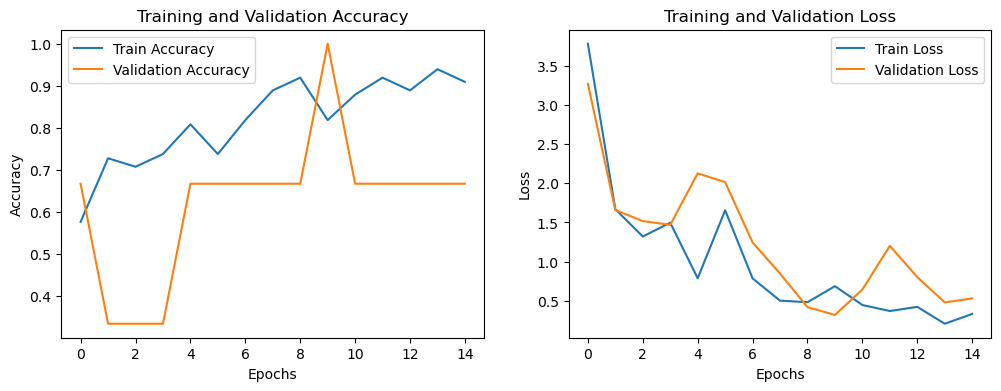

1/1 [==============================] - 0s 225ms/step
Classification Report for VGG16:
              precision    recall  f1-score   support

      cancer       1.00      1.00      1.00         2
  non-cancer       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



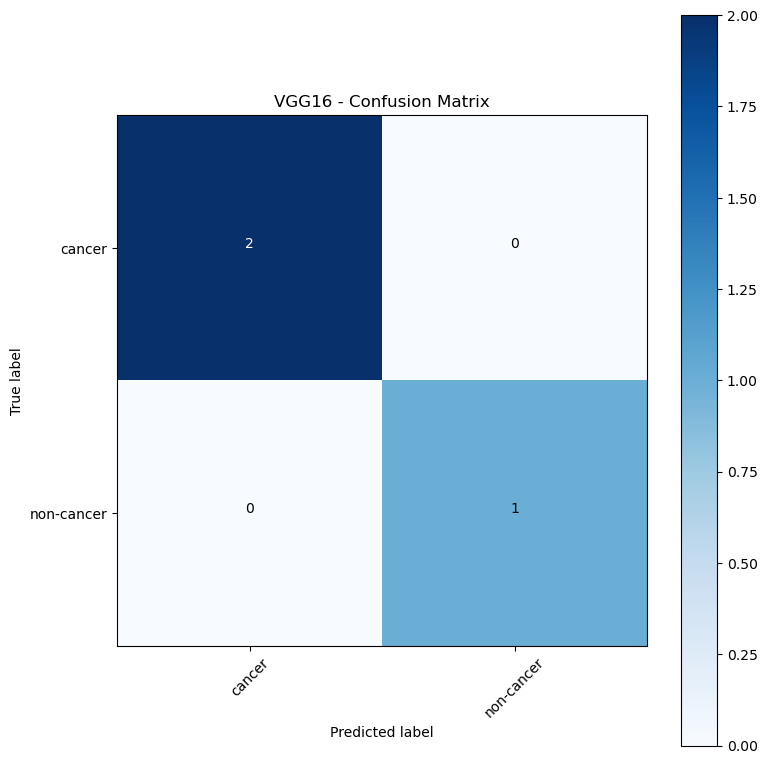

IndexError: index 1 is out of bounds for axis 1 with size 1

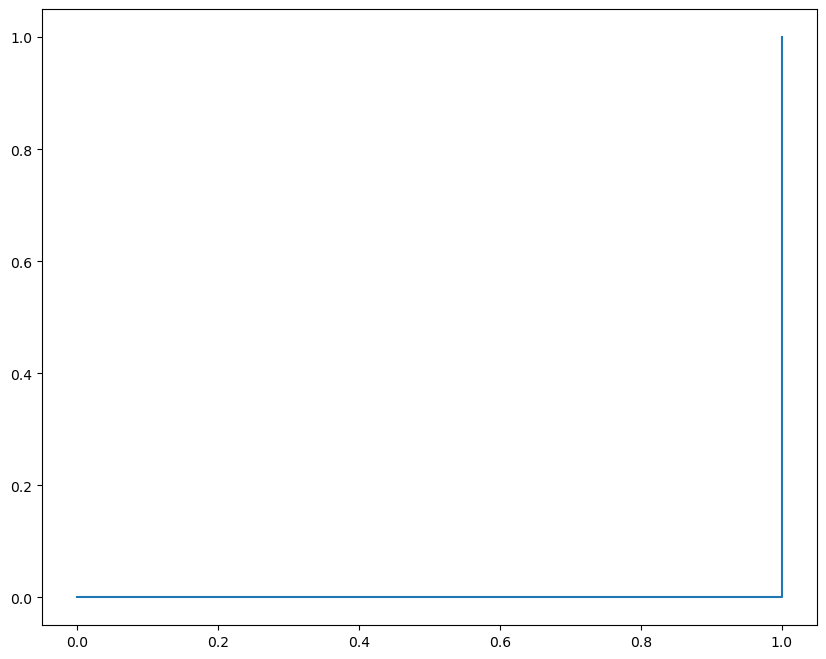

In [3]:
# Plot training history
plot_training_history(history_vgg16)

# Generate predictions and true labels for the test set
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(vgg16_model.predict(test_ds), axis=1)
y_pred_prob = vgg16_model.predict(test_ds)

# Classification Report
print("Classification Report for VGG16:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot Confusion Matrix
def plot_confusion_matrix(cm, class_names, model_name="VGG16"):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Compute and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names, model_name="VGG16")

# Plot ROC Curve
def plot_roc_curve(y_true, y_pred_prob, class_names, model_name="VGG16"):
    y_true_binarized = label_binarize(y_true, classes=[i for i in range(len(class_names))])
    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve for Each Class')
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC curve
plot_roc_curve(y_true, y_pred_prob, class_names, model_name="VGG16")


Found 131 files belonging to 2 classes.
Total dataset size: 3
Training set size: 2
Test set size: 1
Epoch 1/70
2/2 [==============================] - 13s 8s/step - loss: 3.7020 - accuracy: 0.5726 - val_loss: 2.8936 - val_accuracy: 0.6935
Epoch 2/70
2/2 [==============================] - 11s 8s/step - loss: 3.5622 - accuracy: 0.6935 - val_loss: 3.1944 - val_accuracy: 0.6774
Epoch 3/70
2/2 [==============================] - 11s 8s/step - loss: 2.6608 - accuracy: 0.7339 - val_loss: 1.1344 - val_accuracy: 0.7419
Epoch 4/70
2/2 [==============================] - 11s 8s/step - loss: 1.6637 - accuracy: 0.7097 - val_loss: 0.8927 - val_accuracy: 0.8065
Epoch 5/70
2/2 [==============================] - 11s 8s/step - loss: 1.6036 - accuracy: 0.7339 - val_loss: 1.0226 - val_accuracy: 0.8065
Epoch 6/70
2/2 [==============================] - 11s 8s/step - loss: 1.1731 - accuracy: 0.7581 - val_loss: 0.7987 - val_accuracy: 0.8065
Epoch 7/70
2/2 [==============================] - 11s 8s/step - loss: 1.

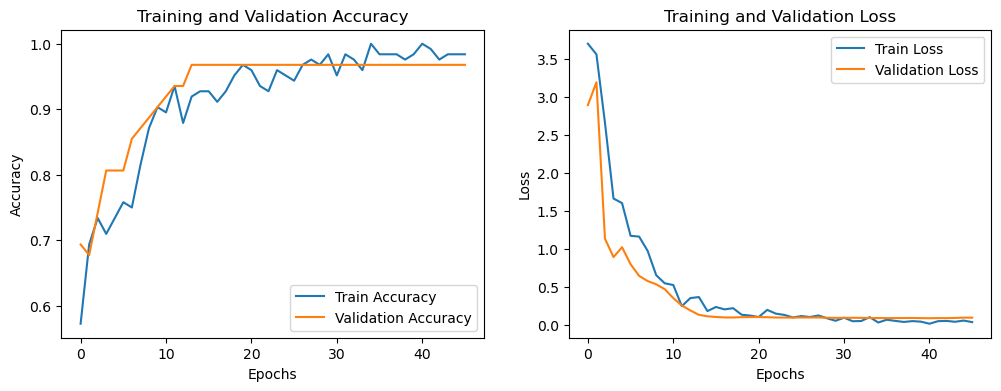

1/1 [==============================] - 4s 4s/step
Classification Report for VGG16:
              precision    recall  f1-score   support

      cancer       0.98      0.98      0.98        42
  non-cancer       0.95      0.95      0.95        20

    accuracy                           0.97        62
   macro avg       0.96      0.96      0.96        62
weighted avg       0.97      0.97      0.97        62



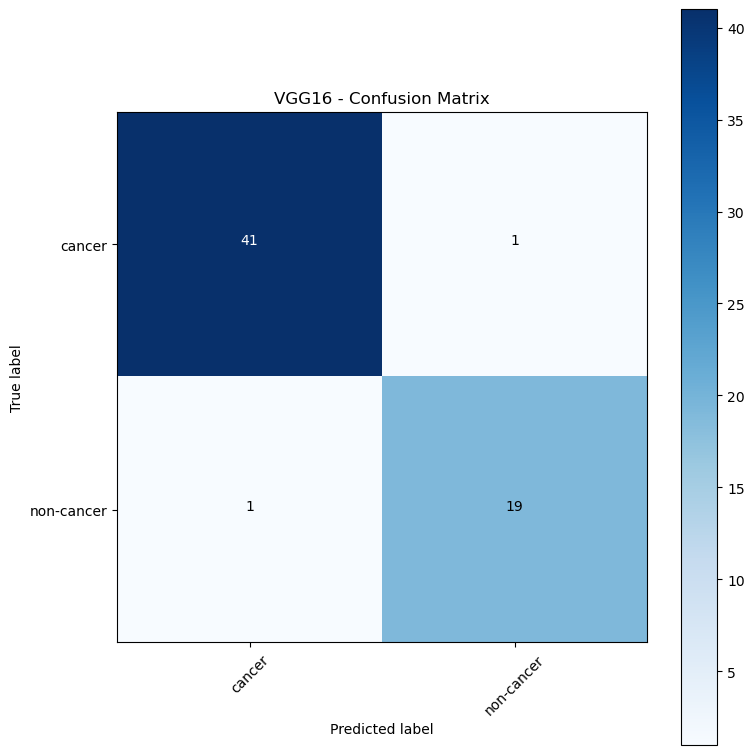

IndexError: index 1 is out of bounds for axis 1 with size 1

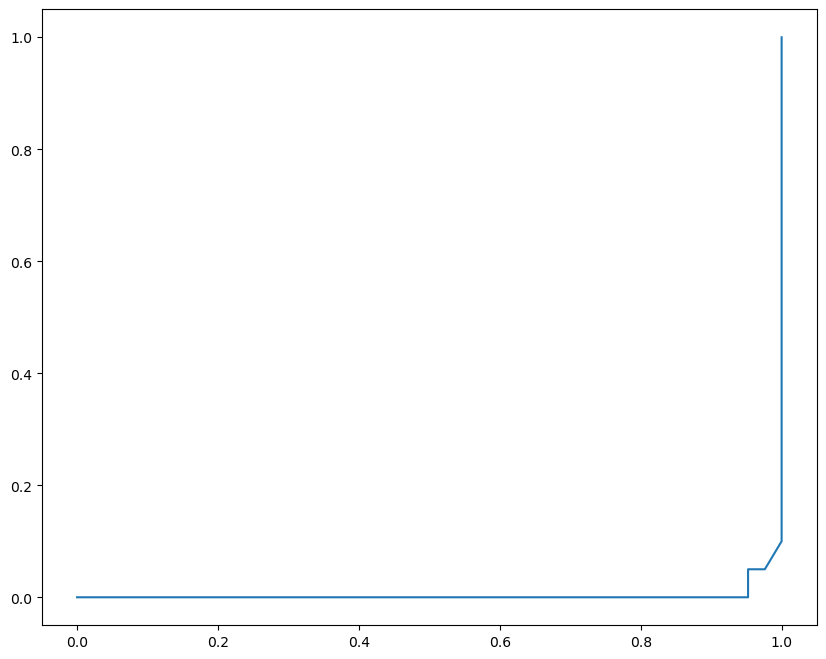

In [5]:
# Imports
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Parameters
BATCH_SIZE = 62
IMAGE_SIZE = 256
EPOCHS = 70
CHANNELS = 3
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
   r'C:\Users\VIT-AP\Desktop\Irfan\archive (2)\OralCancer',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names

# Split dataset into training and testing only
def get_train_test_partition(ds, train_split=0.8, test_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size)
    
    # Print dataset sizes for verification
    print(f"Total dataset size: {ds_size}")
    print(f"Training set size: {len(train_ds)}")
    print(f"Test set size: {len(test_ds)}")
    
    # Autotune both datasets
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return train_ds, test_ds

train_ds, test_ds = get_train_test_partition(dataset)

# Define the VGG16 model with custom dense layers for your classification task
def create_vgg16_model(input_shape, n_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(n_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Instantiate and train the VGG16 model
vgg16_model = create_vgg16_model(input_shape, len(class_names))
history_vgg16 = vgg16_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Evaluate the model on the test set
test_loss_vgg16, test_acc_vgg16 = vgg16_model.evaluate(test_ds)
print(f"VGG16 Test accuracy: {test_acc_vgg16}")

# Plot Training and Validation Accuracy and Loss
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.show()

# Plot training history
plot_training_history(history_vgg16)

# Generate predictions and true labels for the test set
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(vgg16_model.predict(test_ds), axis=1)
y_pred_prob = vgg16_model.predict(test_ds)

# Classification Report
print("Classification Report for VGG16:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot Confusion Matrix
def plot_confusion_matrix(cm, class_names, model_name="VGG16"):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Compute and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names, model_name="VGG16")

# Plot ROC Curve
def plot_roc_curve(y_true, y_pred_prob, class_names, model_name="VGG16"):
    y_true_binarized = label_binarize(y_true, classes=[i for i in range(len(class_names))])
    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve for Each Class')
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC curve
plot_roc_curve(y_true, y_pred_prob, class_names, model_name="VGG16")


Found 131 files belonging to 2 classes.
Total dataset size: 3
Training set size: 2
Test set size: 1
Epoch 1/70
2/2 [==============================] - 9s 4s/step - loss: 37.9935 - accuracy: 0.3548 - val_loss: 9.3736 - val_accuracy: 0.3065
Epoch 2/70
2/2 [==============================] - 3s 2s/step - loss: 24.7069 - accuracy: 0.4355 - val_loss: 27.9167 - val_accuracy: 0.6774
Epoch 3/70
2/2 [==============================] - 3s 2s/step - loss: 25.8332 - accuracy: 0.6613 - val_loss: 22.3127 - val_accuracy: 0.6774
Epoch 4/70
2/2 [==============================] - 3s 2s/step - loss: 18.4218 - accuracy: 0.6774 - val_loss: 7.6785 - val_accuracy: 0.6774
Epoch 5/70
2/2 [==============================] - 3s 2s/step - loss: 7.8651 - accuracy: 0.6935 - val_loss: 8.7344 - val_accuracy: 0.3710
Epoch 6/70
2/2 [==============================] - 3s 2s/step - loss: 12.6173 - accuracy: 0.5000 - val_loss: 7.1895 - val_accuracy: 0.4355
Epoch 7/70
2/2 [==============================] - 3s 2s/step - loss: 7.

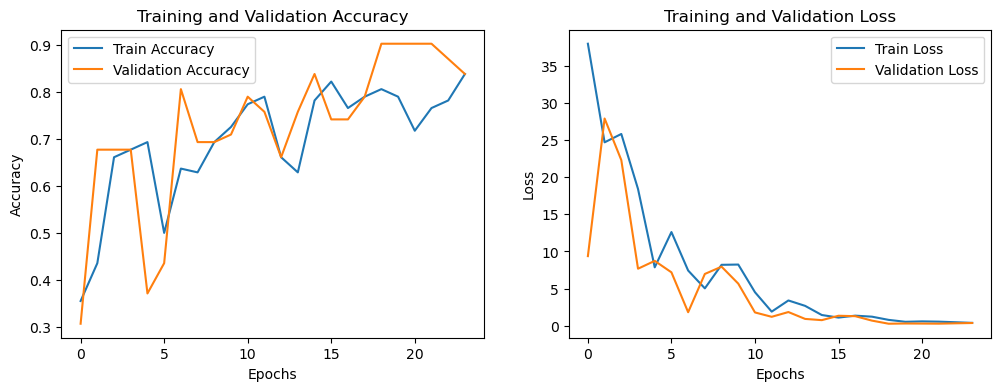

1/1 [==============================] - 1s 873ms/step
Classification Report for InceptionV3:
              precision    recall  f1-score   support

      cancer       0.88      1.00      0.93        42
  non-cancer       1.00      0.70      0.82        20

    accuracy                           0.90        62
   macro avg       0.94      0.85      0.88        62
weighted avg       0.92      0.90      0.90        62



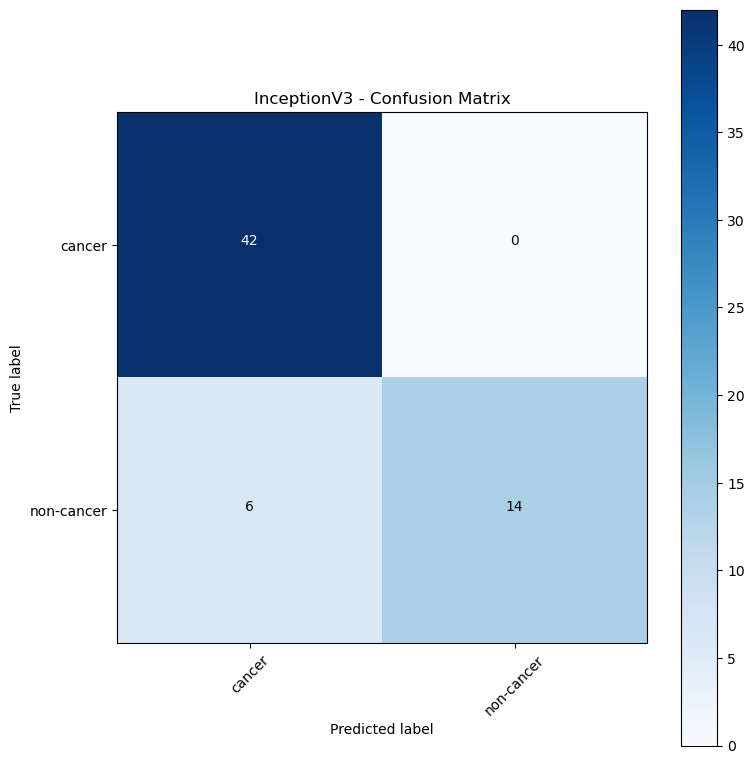

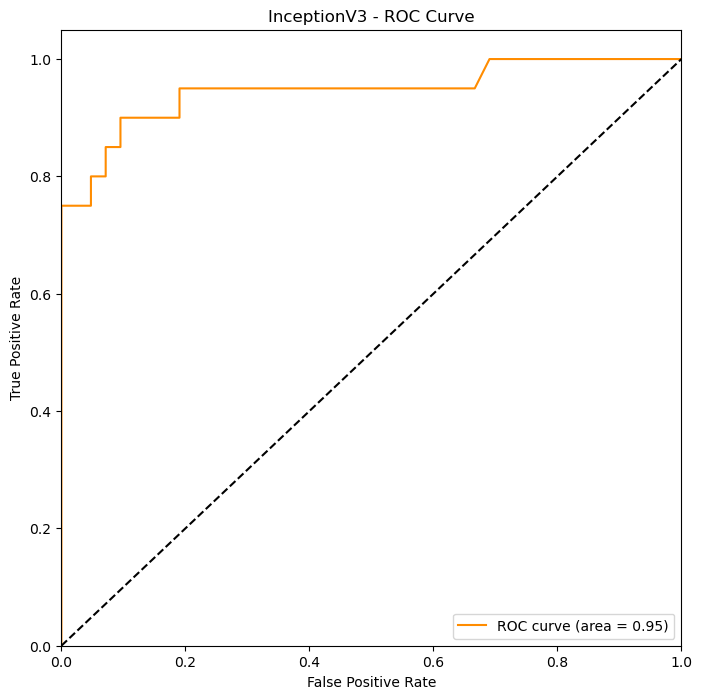

In [11]:
# Imports
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Parameters
BATCH_SIZE = 62
IMAGE_SIZE = 256
EPOCHS = 70
CHANNELS = 3
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
   r'C:\Users\VIT-AP\Desktop\Irfan\archive (2)\OralCancer',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names

# Split dataset into training and testing only
def get_train_test_partition(ds, train_split=0.8, test_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size)
    
    # Print dataset sizes for verification
    print(f"Total dataset size: {ds_size}")
    print(f"Training set size: {len(train_ds)}")
    print(f"Test set size: {len(test_ds)}")
    
    # Autotune both datasets
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return train_ds, test_ds

train_ds, test_ds = get_train_test_partition(dataset)

# Define the InceptionV3 model with custom dense layers for your classification task
def create_inceptionv3_model(input_shape, n_classes):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(n_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Instantiate and train the InceptionV3 model
inceptionv3_model = create_inceptionv3_model(input_shape, len(class_names))
history_inceptionv3 = inceptionv3_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Evaluate the model on the test set
test_loss_inceptionv3, test_acc_inceptionv3 = inceptionv3_model.evaluate(test_ds)
print(f"InceptionV3 Test accuracy: {test_acc_inceptionv3}")

# Plot Training and Validation Accuracy and Loss
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.show()

# Plot training history
plot_training_history(history_inceptionv3)

# Generate predictions and true labels for the test set
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(inceptionv3_model.predict(test_ds), axis=1)
y_pred_prob = inceptionv3_model.predict(test_ds)

# Classification Report
print("Classification Report for InceptionV3:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot Confusion Matrix
def plot_confusion_matrix(cm, class_names, model_name="InceptionV3"):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Compute and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names, model_name="InceptionV3")

# Plot ROC Curve
def plot_roc_curve(y_true, y_pred_prob, class_names, model_name="InceptionV3"):
    try:
        # Check if binary or multi-class classification
        if len(class_names) == 2:
            # Binary classification ROC curve
            y_true_binarized = np.where(np.array(y_true) == 1, 1, 0)
            fpr, tpr, _ = roc_curve(y_true_binarized, y_pred_prob[:, 1])
            roc_auc = auc(fpr, tpr)
            
            plt.figure(figsize=(8, 8))
            plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'{model_name} - ROC Curve')
            plt.legend(loc="lower right")
            plt.show()
        else:
            # Multi-class ROC curve
            y_true_binarized = label_binarize(y_true, classes=[i for i in range(len(class_names))])
            
            plt.figure(figsize=(10, 8))
            for i in range(len(class_names)):
                fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

            plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'{model_name} - ROC Curve for Each Class')
            plt.legend(loc='lower right')
            plt.show()
    except IndexError as e:
        print("IndexError:", e)
        print("This error often occurs if y_pred_prob doesn't match the number of classes.")
    except Exception as e:
        print("Error:", e)
        print("Please check that y_true and y_pred_prob are correctly shaped.")

# Plot ROC Curve
plot_roc_curve(y_true, y_pred_prob, class_names, model_name="InceptionV3")


Found 131 files belonging to 2 classes.
Total dataset size: 3
Training set size: 2
Test set size: 1
Epoch 1/70
2/2 [==============================] - 7s 3s/step - loss: 0.8200 - accuracy: 0.6613 - val_loss: 0.9457 - val_accuracy: 0.6774
Epoch 2/70
2/2 [==============================] - 2s 1s/step - loss: 0.9210 - accuracy: 0.6774 - val_loss: 0.4607 - val_accuracy: 0.7581
Epoch 3/70
2/2 [==============================] - 2s 1s/step - loss: 0.7234 - accuracy: 0.6855 - val_loss: 0.5826 - val_accuracy: 0.6935
Epoch 4/70
2/2 [==============================] - 2s 1s/step - loss: 0.6527 - accuracy: 0.7016 - val_loss: 0.4328 - val_accuracy: 0.7903
Epoch 5/70
2/2 [==============================] - 2s 1s/step - loss: 0.5532 - accuracy: 0.7742 - val_loss: 0.5156 - val_accuracy: 0.7419
Epoch 6/70
2/2 [==============================] - 2s 1s/step - loss: 0.4580 - accuracy: 0.8065 - val_loss: 0.4645 - val_accuracy: 0.7581
Epoch 7/70
2/2 [==============================] - 2s 1s/step - loss: 0.4729 - 

2/2 [==============================] - 2s 1s/step - loss: 0.0667 - accuracy: 0.9919 - val_loss: 0.1404 - val_accuracy: 0.9677
Epoch 59/70
2/2 [==============================] - 2s 1s/step - loss: 0.0567 - accuracy: 0.9839 - val_loss: 0.1453 - val_accuracy: 0.9677
Epoch 60/70
2/2 [==============================] - 2s 1s/step - loss: 0.0789 - accuracy: 0.9758 - val_loss: 0.1352 - val_accuracy: 0.9677
Epoch 61/70
2/2 [==============================] - 2s 1s/step - loss: 0.0568 - accuracy: 0.9919 - val_loss: 0.1315 - val_accuracy: 0.9677
Epoch 62/70
2/2 [==============================] - 2s 1s/step - loss: 0.0580 - accuracy: 0.9758 - val_loss: 0.1322 - val_accuracy: 0.9677
Epoch 63/70
2/2 [==============================] - 2s 1s/step - loss: 0.0624 - accuracy: 0.9919 - val_loss: 0.1362 - val_accuracy: 0.9677
Epoch 64/70
2/2 [==============================] - 2s 1s/step - loss: 0.0723 - accuracy: 0.9758 - val_loss: 0.1357 - val_accuracy: 0.9677
Epoch 65/70
2/2 [=============================

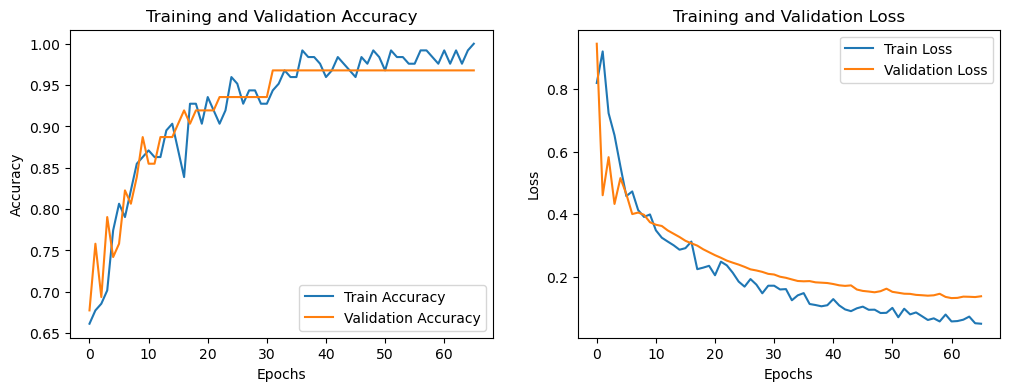

1/1 [==============================] - 1s 723ms/step
Classification Report for MobileNetV2:
              precision    recall  f1-score   support

      cancer       0.98      0.98      0.98        42
  non-cancer       0.95      0.95      0.95        20

    accuracy                           0.97        62
   macro avg       0.96      0.96      0.96        62
weighted avg       0.97      0.97      0.97        62



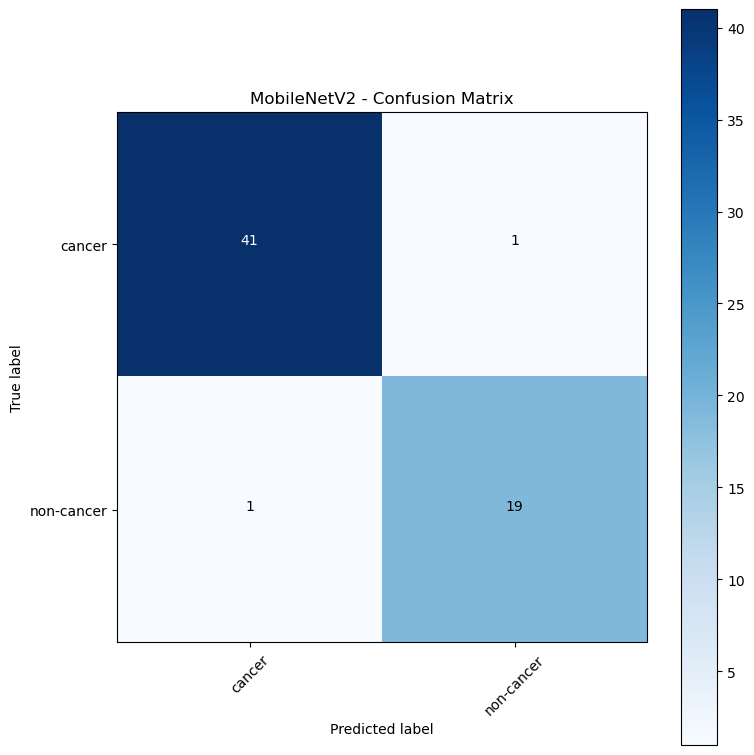

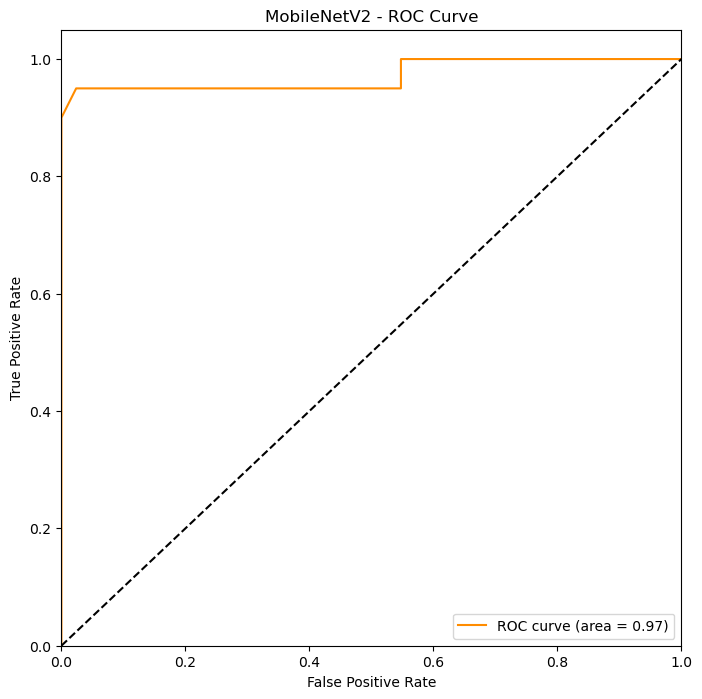

In [12]:
# Imports
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Parameters
BATCH_SIZE = 62
IMAGE_SIZE = 256
EPOCHS = 70
CHANNELS = 3
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
   r'C:\Users\VIT-AP\Desktop\Irfan\archive (2)\OralCancer',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names

# Split dataset into training and testing only
def get_train_test_partition(ds, train_split=0.8, test_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size)
    
    # Print dataset sizes for verification
    print(f"Total dataset size: {ds_size}")
    print(f"Training set size: {len(train_ds)}")
    print(f"Test set size: {len(test_ds)}")
    
    # Autotune both datasets
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return train_ds, test_ds

train_ds, test_ds = get_train_test_partition(dataset)

# Define the MobileNetV2 model with custom dense layers for your classification task
def create_mobilenetv2_model(input_shape, n_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(n_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Instantiate and train the MobileNetV2 model
mobilenetv2_model = create_mobilenetv2_model(input_shape, len(class_names))
history_mobilenetv2 = mobilenetv2_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Evaluate the model on the test set
test_loss_mobilenetv2, test_acc_mobilenetv2 = mobilenetv2_model.evaluate(test_ds)
print(f"MobileNetV2 Test accuracy: {test_acc_mobilenetv2}")

# Plot Training and Validation Accuracy and Loss
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.show()

# Plot training history
plot_training_history(history_mobilenetv2)

# Generate predictions and true labels for the test set
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(mobilenetv2_model.predict(test_ds), axis=1)
y_pred_prob = mobilenetv2_model.predict(test_ds)

# Classification Report
print("Classification Report for MobileNetV2:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot Confusion Matrix
def plot_confusion_matrix(cm, class_names, model_name="MobileNetV2"):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Compute and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names, model_name="MobileNetV2")

# Plot ROC Curve
def plot_roc_curve(y_true, y_pred_prob, class_names, model_name="MobileNetV2"):
    try:
        # Check if binary or multi-class classification
        if len(class_names) == 2:
            # Binary classification ROC curve
            y_true_binarized = np.where(np.array(y_true) == 1, 1, 0)
            fpr, tpr, _ = roc_curve(y_true_binarized, y_pred_prob[:, 1])
            roc_auc = auc(fpr, tpr)
            
            plt.figure(figsize=(8, 8))
            plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'{model_name} - ROC Curve')
            plt.legend(loc="lower right")
            plt.show()
        else:
            # Multi-class ROC curve
            y_true_binarized = label_binarize(y_true, classes=[i for i in range(len(class_names))])
            
            plt.figure(figsize=(10, 8))
            for i in range(len(class_names)):
                fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

            plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'{model_name} - ROC Curve for Each Class')
            plt.legend(loc='lower right')
            plt.show()
    except IndexError as e:
        print("IndexError:", e)
        print("This error often occurs if y_pred_prob doesn't match the number of classes.")
    except Exception as e:
        print("Error:", e)
        print("Please check that y_true and y_pred_prob are correctly shaped.")

# Plot ROC Curve
plot_roc_curve(y_true, y_pred_prob, class_names, model_name="MobileNetV2")


Found 131 files belonging to 2 classes.
Total dataset size: 3
Training set size: 2
Test set size: 1
Epoch 1/70
2/2 [==============================] - 14s 6s/step - loss: 2.9518 - accuracy: 0.6129 - val_loss: 3.7449 - val_accuracy: 0.6774
Epoch 2/70
2/2 [==============================] - 5s 4s/step - loss: 3.2111 - accuracy: 0.6855 - val_loss: 1.1530 - val_accuracy: 0.6613
Epoch 3/70
2/2 [==============================] - 5s 4s/step - loss: 1.9668 - accuracy: 0.5726 - val_loss: 1.0000 - val_accuracy: 0.5645
Epoch 4/70
2/2 [==============================] - 5s 4s/step - loss: 1.6507 - accuracy: 0.6210 - val_loss: 0.8121 - val_accuracy: 0.6935
Epoch 5/70
2/2 [==============================] - 5s 4s/step - loss: 1.4493 - accuracy: 0.6290 - val_loss: 0.8829 - val_accuracy: 0.7419
Epoch 6/70
2/2 [==============================] - 5s 4s/step - loss: 1.1165 - accuracy: 0.7419 - val_loss: 1.2530 - val_accuracy: 0.7419
Epoch 7/70
2/2 [==============================] - 5s 4s/step - loss: 1.1877 -

Epoch 60/70
2/2 [==============================] - 6s 4s/step - loss: 0.1166 - accuracy: 0.9597 - val_loss: 0.1375 - val_accuracy: 0.9677
Epoch 61/70
2/2 [==============================] - 6s 4s/step - loss: 0.1163 - accuracy: 0.9758 - val_loss: 0.1359 - val_accuracy: 0.9677
Epoch 62/70
2/2 [==============================] - 6s 4s/step - loss: 0.1048 - accuracy: 0.9516 - val_loss: 0.1329 - val_accuracy: 0.9677
Epoch 63/70
2/2 [==============================] - 6s 4s/step - loss: 0.1082 - accuracy: 0.9677 - val_loss: 0.1271 - val_accuracy: 0.9677
Epoch 64/70
2/2 [==============================] - 5s 4s/step - loss: 0.1003 - accuracy: 0.9677 - val_loss: 0.1274 - val_accuracy: 0.9677
Epoch 65/70
2/2 [==============================] - 5s 4s/step - loss: 0.0849 - accuracy: 0.9839 - val_loss: 0.1296 - val_accuracy: 0.9677
Epoch 66/70
2/2 [==============================] - 6s 4s/step - loss: 0.0960 - accuracy: 0.9597 - val_loss: 0.1279 - val_accuracy: 0.9677
Epoch 67/70
2/2 [=================

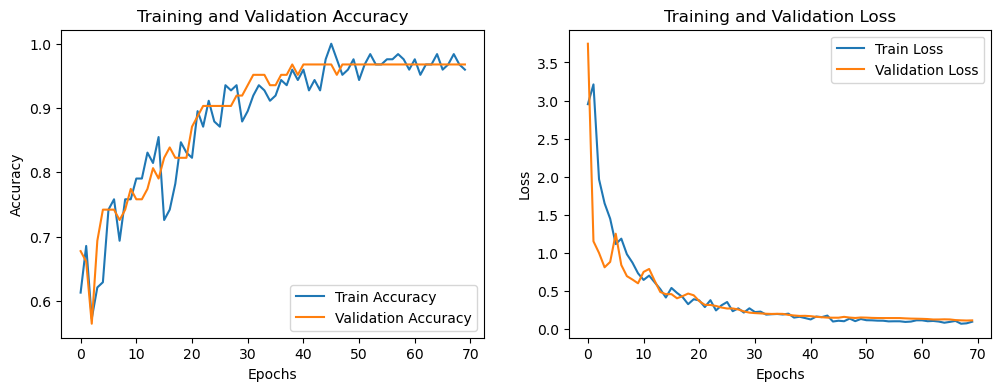

1/1 [==============================] - 2s 2s/step
Classification Report for DenseNet121:
              precision    recall  f1-score   support

      cancer       0.95      1.00      0.98        42
  non-cancer       1.00      0.90      0.95        20

    accuracy                           0.97        62
   macro avg       0.98      0.95      0.96        62
weighted avg       0.97      0.97      0.97        62



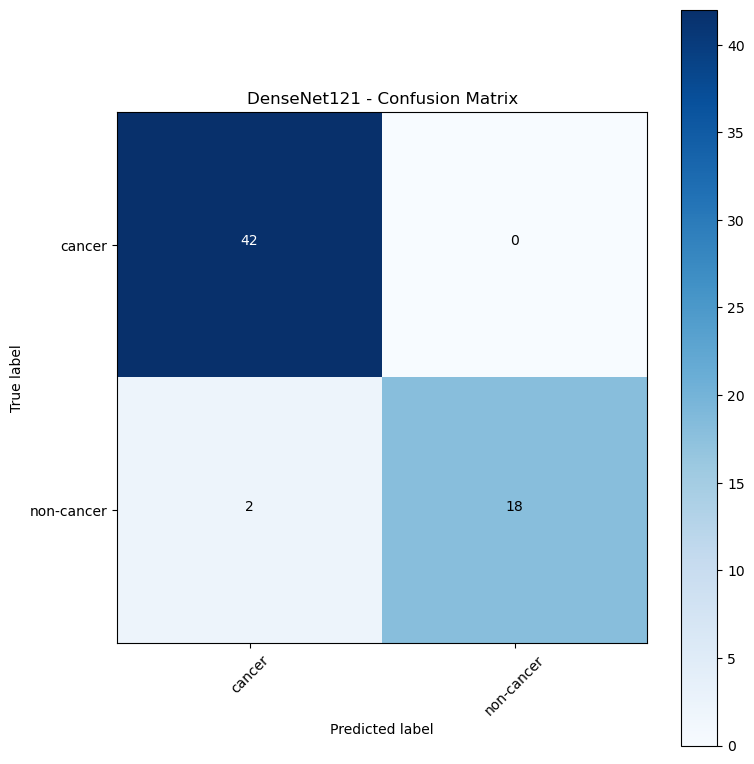

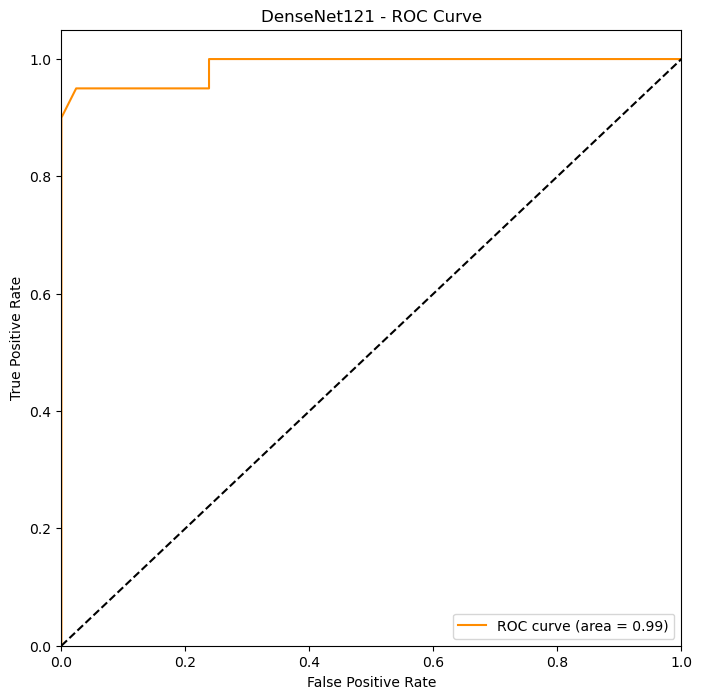

In [13]:
# Imports
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Parameters
BATCH_SIZE = 62
IMAGE_SIZE = 256
EPOCHS = 70
CHANNELS = 3
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
   r'C:\Users\VIT-AP\Desktop\Irfan\archive (2)\OralCancer',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names

# Split dataset into training and testing only
def get_train_test_partition(ds, train_split=0.8, test_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size)
    
    # Print dataset sizes for verification
    print(f"Total dataset size: {ds_size}")
    print(f"Training set size: {len(train_ds)}")
    print(f"Test set size: {len(test_ds)}")
    
    # Autotune both datasets
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return train_ds, test_ds

train_ds, test_ds = get_train_test_partition(dataset)

# Define the DenseNet121 model with custom dense layers for your classification task
def create_densenet121_model(input_shape, n_classes):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(n_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Instantiate and train the DenseNet121 model
densenet121_model = create_densenet121_model(input_shape, len(class_names))
history_densenet121 = densenet121_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Evaluate the model on the test set
test_loss_densenet121, test_acc_densenet121 = densenet121_model.evaluate(test_ds)
print(f"DenseNet121 Test accuracy: {test_acc_densenet121}")

# Plot Training and Validation Accuracy and Loss
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.show()

# Plot training history
plot_training_history(history_densenet121)

# Generate predictions and true labels for the test set
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(densenet121_model.predict(test_ds), axis=1)
y_pred_prob = densenet121_model.predict(test_ds)

# Classification Report
print("Classification Report for DenseNet121:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot Confusion Matrix
def plot_confusion_matrix(cm, class_names, model_name="DenseNet121"):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Compute and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names, model_name="DenseNet121")

# Plot ROC Curve
def plot_roc_curve(y_true, y_pred_prob, class_names, model_name="DenseNet121"):
    try:
        # Check if binary or multi-class classification
        if len(class_names) == 2:
            # Binary classification ROC curve
            y_true_binarized = np.where(np.array(y_true) == 1, 1, 0)
            fpr, tpr, _ = roc_curve(y_true_binarized, y_pred_prob[:, 1])
            roc_auc = auc(fpr, tpr)
            
            plt.figure(figsize=(8, 8))
            plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'{model_name} - ROC Curve')
            plt.legend(loc="lower right")
            plt.show()
        else:
            # Multi-class ROC curve
            y_true_binarized = label_binarize(y_true, classes=[i for i in range(len(class_names))])
            
            plt.figure(figsize=(10, 8))
            for i in range(len(class_names)):
                fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

            plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'{model_name} - ROC Curve for Each Class')
            plt.legend(loc='lower right')
            plt.show()
    except IndexError as e:
        print("IndexError:", e)
        print("This error often occurs if y_pred_prob doesn't match the number of classes.")
    except Exception as e:
        print("Error:", e)
        print("Please check that y_true and y_pred_prob are correctly shaped.")

# Plot ROC Curve
plot_roc_curve(y_true, y_pred_prob, class_names, model_name="DenseNet121")
